# **Imports**

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os 
from sklearn import svm
import pickle



# **Load Data**

In [2]:
def toNumpy(x_train, y_train, x_test, y_test):
    for i in x_train.keys():
        x_train[i] = np.array(x_train[i])
        y_train[i] = np.array(y_train[i])
    for i in x_test.keys():
        x_test[i] = np.array(x_test[i])
        y_test[i] = np.array(y_test[i])
    return x_train, y_train, x_test, y_test
    

In [3]:
def loadData(folders_name:list):
    x_train = {}
    y_train = {}
    x_test =  {}
    y_test =  {}
    
    for name in folders_name:        
        path = f".\\data\\{name}\\Train\\" 
        data = pd.read_csv(path+f"{name}_SigVerificationTrainLabels.csv") 
        data  = data.loc[:,["image_name","label"]].astype(str)
        data = data.reset_index() 
        # li =labels.loc[:,["label"]].astype(str)
        x_train[name] = []
        y_train[name] = []
        x_test[name] =  []
        y_test[name] =  []

        # print(data.head())
        for i,r in data.iterrows():

            imgName = str(r["image_name"])
            img=cv2.imread(path+imgName, 0)
            # img = img.astype(np.float32)    
            x_train[name].append(img)
            
            l =  str(r["label"])
            y_train[name].append(1) if l == "real" else y_train[name].append(0) 
            
        "#====================================================================================" 
        
        path = f".\\data\\{name}\\Test\\" 
        data = pd.read_csv(path+f"{name}_SigVerificationTestLabels.csv")
        data = data.reset_index()  
        data  = data.loc[:,["image_name","label"]].astype(str)
        data = data.reset_index()
        
        for i,r in data.iterrows():
            imgName = str(r["image_name"])
            img=cv2.imread(path+imgName, 0)
            # img = img.astype(np.float32)       
            x_test[name].append(img)
            
            l =  str(r["label"])
            y_test[name].append(1) if l == "real" else y_test[name].append(0) 
            
            
            
    return toNumpy(x_train, y_train, x_test, y_test)

#   **Extract Features**

In [4]:
def normalization(features:np.ndarray, o):
    if o == 1:
        m = features.mean(axis=1)
        s = features.std(axis=1) 
        features = (features.T-m)/(s+1e-7)
        return features.T.flatten()
    if features.ndim > 1:
        features = features.flatten()
    m = features.mean()
    s = features.std()
    return (features-m)/(s+1e-7)


In [5]:
def featureExtractionM(img,o=0):
    features=0
    if o == 0: 
        hog = cv2.HOGDescriptor()
        img= cv2.resize(img, (64,128))
        features = hog.compute(img)
        features = normalization(features, o)

    elif o == 1:
        sift = cv2.SIFT_create()
        img= cv2.resize(img, (128,128))
        kp1, features = sift.detectAndCompute(img,None)
        if features.shape[0]<=64:
            features = np.concatenate([features,np.zeros((64-features.shape[0],128))], axis = 0)
        else:
            features = features[0:64,:]
        features = normalization(features, o)

    elif o == 2:
        img= cv2.resize(img, (64,32))
        features = cv2.Canny(img, 32, 128)
        features = normalization(features, o)
        
    elif o == 3:
        img= cv2.resize(img, (128,64))
        dst = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT,sigmaX=0.1,sigmaY=0.1)
        featuresX = cv2.Sobel(src=dst, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
        featuresY = cv2.Sobel(src=dst, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
        features =np.arctan(featuresY/(featuresX+1e-7))
        # sobelxy = cv2.Sobel(src=dst, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
        features = normalization(features, o)        
        
    elif o == 4:
        img= cv2.resize(img, (128,64))
        dst = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT,sigmaX=0.1,sigmaY=0.1)
        featuresX = cv2.Sobel(src=dst, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
        featuresY = cv2.Sobel(src=dst, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
        features = featuresY + featuresX
        features = normalization(features, o) 
        
    elif o == 5:
        img = np.float32(img)
        features = cv2.cornerHarris(img,2,3,0.04)
        #result is dilated for marking the corners, not important
        features = cv2.dilate(features,None) 
        features = normalization(features, o)    
        features = features[features>0.01]  
        if features.shape[0]<=15000:
            features = np.concatenate([features,np.zeros((15000-features.shape[0]))], axis = 0)
        else:
            features = features[0:15000]
    return features


In [6]:
def extract(x_train,x_test, o=0):
    for name in x_train.keys():
        x_featuresTrain = []
        for i in x_train[name]:
            f = featureExtractionM(i,o)
            x_featuresTrain.append(f)
        x_train[name] = np.array(x_featuresTrain)
        
        x_featuresTest = []   
        for i in x_test[name]:
            f = featureExtractionM(i,o)
            x_featuresTest.append(f)
        x_test[name] = np.array(x_featuresTest)
    return x_train,x_test

#   **Svm Classifier**

In [7]:
def buildSvm(x_train, y_train):
    Svms = {}
    for name in x_train.keys():
        Svms[name] = svm.SVC(C=10,kernel="rbf",gamma="auto", )
        Svms[name].fit(x_train[name], y_train[name])
    return Svms

In [8]:
def score(Svms, x, y):
    scores={}
    for name in x.keys():
       scores[name] = Svms[name].score(x[name] , y[name])
    return scores

#   **Test**

In [9]:
folders_name=["personA","personB","personC","personD","personE"]

In [10]:
x_train, y_train, x_test, y_test = loadData(folders_name)

C:\Users\Hassan\AppData\Local\Temp\ipykernel_4444\3107238934.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train[i] = np.array(x_train[i])
C:\Users\Hassan\AppData\Local\Temp\ipykernel_4444\3107238934.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test[i] = np.array(x_test[i])


In [11]:
x_train,x_test = extract(x_train,x_test, o=0)

In [12]:
x_train["personA"][2].shape

(3780,)

In [12]:
Svms = buildSvm(x_train, y_train)

In [13]:
strain = score(Svms, x_train, y_train)
stest = score(Svms, x_test, y_test)

In [14]:
strain,'=================\n', stest

({'personA': 1.0,
  'personB': 1.0,
  'personC': 1.0,
  'personD': 1.0,
  'personE': 1.0},
 '=================\n',
 {'personA': 0.875,
  'personB': 0.625,
  'personC': 1.0,
  'personD': 0.875,
  'personE': 1.0})

In [16]:
pickle.dump(Svms, open("part2.pkl", 'wb'))

# **===================================**

In [17]:
x_featuresTrain = []
y_featuresTrain = []
for name in x_train.keys():
    x_featuresTrain.extend(x_train[name])
    y_featuresTrain.extend(y_train[name])

In [18]:
x_featuresTest = []
y_featuresTest = []
for name in x_test.keys():
    x_featuresTest.extend(x_test[name])
    y_featuresTest.extend(y_test[name])

In [19]:
s = svm.SVC(C=10,kernel="rbf",gamma="auto", )
s.fit(x_featuresTrain, y_featuresTrain)

SVC(C=10, gamma='auto')

In [20]:
s.score(x_featuresTrain , y_featuresTrain)


1.0

In [21]:
s.score(x_featuresTest , y_featuresTest)

0.85

In [ ]:
pickle.dump(s, open("part2_2.pkl", 'wb'))

<Figure size 1200x1000 with 0 Axes>

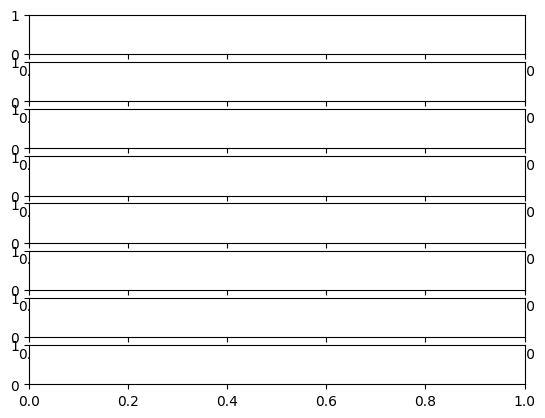

In [40]:
fig = plt.figure(figsize=(12, 10))
figg,ax = plt.subplots(8)

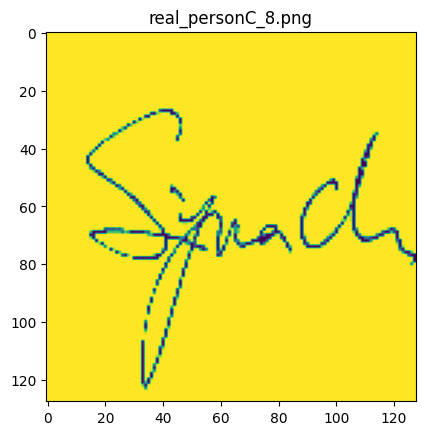

In [65]:
x =  cv2.imread("data/personC/Test/personC_8.png",0)
f = featureExtractionM(x,o=0)
s = Svms["personC"].predict(np.reshape(f,(1,-1)))
x= cv2.resize(x, (128,128))
plt.imshow(x)
plt.title("forged_personC_8.png"if s == 0 else "real_personC_8.png")


plt.show()